In [1]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from rail.raruma import utility_functions as raruma_util
from rail.raruma import plotting_functions as raruma_plot
from rail.raruma import admixture_functions as raruma_admix
from rail.raruma import wrapper_classes as raruma_wrap
from scipy.stats import sigmaclip
from astropy.stats import biweight_location, biweight_scale


In [2]:
# pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'  
# if that fails you can use this
# pz_dir = '/global/u2/e/echarles/dx'
pz_dir = '/Users/echarles/pz'

In [3]:
train = tables_io.read(f"{pz_dir}/data/train/dp1_ecdfs_matched_specgold_train.hdf5")
test = tables_io.read(f"{pz_dir}/data/test/dp1_ecdfs_matched_specgold_test.hdf5")
#d.keys()
#train = tables_io.sliceObj(d, slice(0, -1, 10))
#test = tables_io.sliceObj(d, slice(1, -1, 10))
d = tables_io.read(f"{pz_dir}/data/on_sky/dp1_v29.0.0_gold_all.hdf5")
model_file_knn = './model_inform_knn.pkl'
model_file_bpz = './model_inform_bpz.pkl'
model_file_fzb = './model_inform_fzboost.pkl'
model_file_gpz = './model_inform_gpz.pkl'

In [4]:
from rail.estimation.algos.k_nearneigh import KNearNeighEstimator
from rail.estimation.algos.bpz_lite import BPZliteEstimator
from rail.estimation.algos.flexzboost import FlexZBoostEstimator
from rail.estimation.algos.gpz import GPzEstimator
from rail.utils.catalog_utils import RubinCatalogConfig
RubinCatalogConfig.apply(RubinCatalogConfig.tag)
band_names = raruma_util.make_band_names('LSST_obs_{band}', 'ugrizy')
error_band_names = raruma_util.make_band_names('LSST_obs_{band}_err', 'ugrizy')

In [5]:
train_features = raruma_util.get_band_values(train, '{band}_gaap1p0Mag', 'ugrizy')
error_bands = raruma_util.get_band_values(train, '{band}_gaap1p0MagErr', 'ugrizy')

In [6]:
library = raruma_util.get_band_values(d, '{band}_gaap1p0Mag', 'ugrizy')

In [7]:
knn = KNearNeighEstimator.make_stage(name='knn', model=model_file_knn, input='dummy.in', output_mode='return', nzbins=3001)
knn.stage_columns = knn.config.bands
knn_w = raruma_wrap.CatEstimatorWrapper(knn, band_names)

Inserting handle into data store.  model: ./model_inform_knn.pkl, knn


In [8]:
gpz = KNearNeighEstimator.make_stage(name='gpz', model=model_file_gpz, input='dummy.in', output_mode='return', nzbins=3001)
gpz.stage_columns = gpz.config.bands
gpz_w = raruma_wrap.CatEstimatorWrapper(gpz, band_names)

In [9]:
bpz = BPZliteEstimator.make_stage(name='bpz', model=model_file_bpz, input='dummy.in', output_mode='return', nzbins=3001)
bpz.stage_columns = bpz.config.bands
bpz_w = raruma_wrap.CatEstimatorWrapper(bpz, band_names+error_band_names)

In [19]:
fzb = FlexZBoostEstimator.make_stage(name='fzboost', model=model_file_fzb, input='dummy.in', output_mode='return', nzbins=3001, calc_summary_stats=True)
fzb.stage_columns = fzb.config.bands
fzb_w = raruma_wrap.CatEstimatorWrapper(fzb, band_names+error_band_names, point_estimate='z_mode')

Inserting handle into data store.  model: ./model_inform_fzboost.pkl, fzboost


In [11]:
admix_grid = np.logspace(-4, 0, 17)

In [12]:
band_names+error_band_names

['LSST_obs_u',
 'LSST_obs_g',
 'LSST_obs_r',
 'LSST_obs_i',
 'LSST_obs_z',
 'LSST_obs_y',
 'LSST_obs_u_err',
 'LSST_obs_g_err',
 'LSST_obs_r_err',
 'LSST_obs_i_err',
 'LSST_obs_z_err',
 'LSST_obs_y_err']

In [15]:
def doit(wrapper, nclip=3):
    the_dict = {}
    inputs = np.hstack([train_features, error_bands])
    est_orig = wrapper(inputs.T)
    means = []
    stds = []
    outlier_fracs = []
    for admix in admix_grid:
        mixed_mags = raruma_admix.make_admixture(train_features, library, admixture=admix)
        inputs = np.hstack([mixed_mags, error_bands])
        ad_vals = wrapper(inputs.T)
        raruma_plot
        deltas = (ad_vals - est_orig)/(1 + est_orig)
        subset_clip, _, _ = sigmaclip(deltas, low=3, high=3)
        for _j in range(nclip):
            subset_clip, _, _ = sigmaclip(subset_clip, low=3, high=3)

        the_dict[admix] = deltas
        outliers = (np.fabs(deltas) > 0.15).sum() / float(deltas.size)
        outlier_fracs.append(outliers)
        #means.append(deltas.mean())
        #stds.append(deltas.std())
        means.append(biweight_location(subset_clip))
        stds.append(biweight_scale(subset_clip))

    _ = plt.plot(admix_grid, means, label=r"mean $\delta z$")
    _ = plt.plot(admix_grid, stds, label=r"RMS $\delta z$")
    _ = plt.plot(admix_grid, outlier_fracs, label=r"f $\delta z > 0.15$")
    _ = plt.xscale('log')
    _ = plt.legend()
    _ = plt.xlabel("Flux Admixture Fraction")
    _ = plt.ylabel(r"$\delta z$")

Process 0 estimating PZ PDF for rows 0 - 4,803


/Users/echarles/miniconda3/envs/rail/lib/python3.13/site-packages/scipy/stats/_distn_infrastructure.py:1451: RuntimeWarning: invalid value encountered in sqrt
  res = sqrt(self.stats(*args, **kwds))


Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store. 

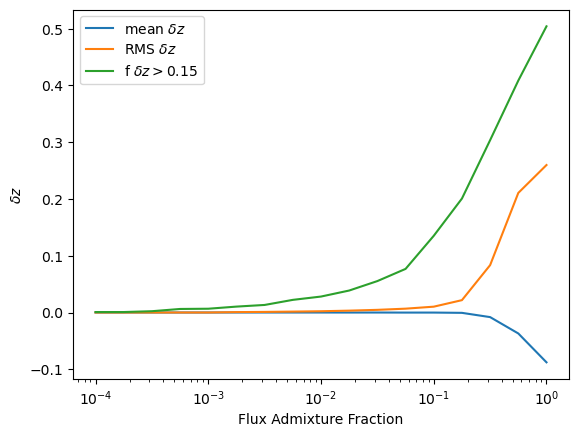

In [20]:
doit(fzb_w)

Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hd

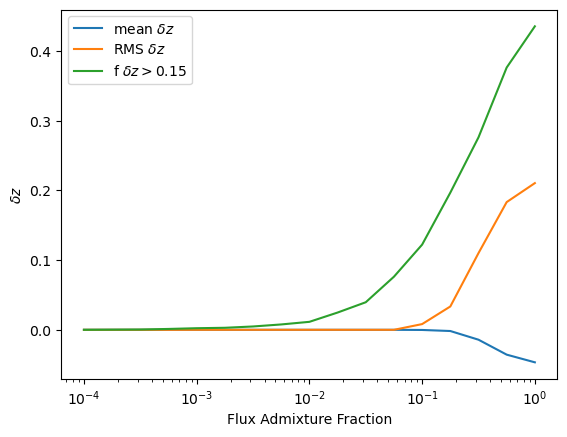

In [17]:
doit(knn_w)

Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hd

/Users/echarles/software/DESC/rail_raruma/src/rail/raruma/admixture_functions.py:51: RuntimeWarning: divide by zero encountered in divide
  pick_weights = total_fluxes / pick_totals
/Users/echarles/software/DESC/rail_raruma/src/rail/raruma/admixture_functions.py:52: RuntimeWarning: invalid value encountered in multiply
  contamination = (pick_fluxes.T * (pick_weights * admixture)).T


Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_gpz: inprogress_output_gpz.hdf5, gpz


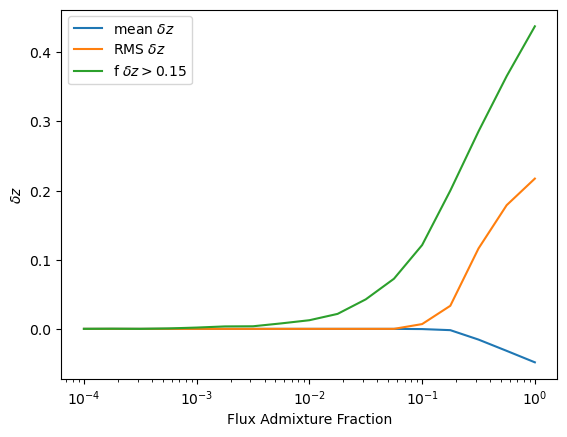

In [18]:
doit(gpz_w)

In [ ]:
for k, v in the_dict.items():
    _ = plt.hist(v, bins=np.linspace(-1, 1, 101), label=k)